* 저장해야 하는 정보들
    * Args 에 포함된 세팅 값
    * Epoch에 따른 train loss, val loss (+acc) 
    * 최종 train acc, val acc, test acc
* 중간에 정보가 손실되는 상황을 방지하기 위해
    * Json 포맷을 활용
    * 파일명은 실험이름 + 실험 세팅 값의 해쉬.json 으로 지정
        * 세팅 값이 dict 형태일 때 문자열로 변환 후 hashing 처리 

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [3]:
mps_device = torch.device("mps")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

In [6]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True,
                                              num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [7]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False,
                                            num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [8]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False,
                                             num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(mps_device)
            labels = labels.to(mps_device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc


In [9]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.to(mps_device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

In [10]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

In [10]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [512, 256, 128]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # == args.name_var1 = var1
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=512, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='Adam', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)
Epoch 0, Acc(train/val): 40.76/45.84, Loss(train/val) 1.70/1.55. Took 28.83 sec
Epoch 1, Acc(train/val): 48.53/46.64, Loss(train/val) 1.47/1.53. Took 28.63 sec
Epoch 2, Acc(train/val): 51.87/49.08, Loss(train/val) 1.38/1.49. Took 28.75 sec
Epoch 3, Acc(train/val): 54.97/49.85, Loss(train/val) 1.30/1.48. Took 28.59 sec
Epoch 4, Acc(train/val): 57.55/50.86, Loss(train/val) 1.23/1.47. Took 28.66 sec
Epoch 5, Acc(train/val): 59.72/51.26, Loss(train/val) 1.16/1.49. Took 28.67 sec
Epoch 6, Acc(train/val): 61.88/50.68, Loss(train/val) 1.10/1.52. Took 28.69 sec
Epoch 7, Acc(train/val): 63.81/51.81, Loss(train/val) 1.05/1.51. Took 28.77 sec
Epoch 8, Acc(train/val): 65.83/51.37, Loss(train/val) 1.00/1.57. Took 28.80 sec
Epoch 9, Acc(train/val): 67.68/50.73, Loss(t

<AxesSubplot: xlabel='n_layer', ylabel='test_acc'>

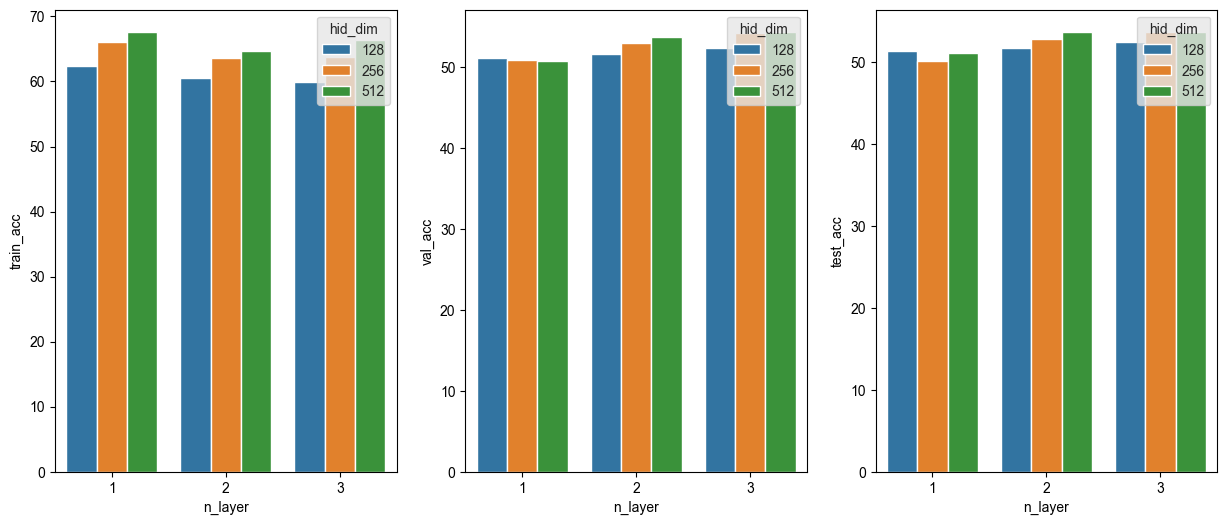

In [12]:

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

In [13]:
df = load_exp_result('exp1')
df.head(20)

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[1.729184932010189, 1.5051688449397969, 1.3889...","[1.5781628489494324, 1.4681145191192626, 1.407...","[37.88, 46.165, 50.465, 52.75, 54.8825, 57.252...","[42.57, 47.3, 50.06, 50.73, 51.47, 52.85, 53.0...",63.8125,54.19,53.68,exp1_n_layer_hid_dim,3072,10,256,relu,0.2,True,0.00001,True,Adam,0.0015,256,3
1,"[1.6838271989943876, 1.4826807785945333, 1.386...","[1.5859968781471252, 1.4928600192070007, 1.466...","[40.8225, 48.1825, 51.725, 53.845, 55.93, 57.5...","[43.96, 48.43, 49.14, 50.9, 50.36, 51.02, 50.0...",62.3725,51.07,51.28,exp1_n_layer_hid_dim,3072,10,128,relu,0.2,True,0.00001,True,Adam,0.0015,256,1
2,"[1.7536163618610163, 1.5276659491715159, 1.432...","[1.595910108089447, 1.4986073970794678, 1.4369...","[37.5, 45.9675, 49.1575, 51.9325, 53.7475, 55....","[44.06, 47.59, 49.66, 49.84, 51.21, 51.0, 52.0...",60.4675,51.57,51.74,exp1_n_layer_hid_dim,3072,10,128,relu,0.2,True,0.00001,True,Adam,0.0015,256,2
3,"[1.6956588978979998, 1.4698951532886286, 1.378...","[1.5544957518577576, 1.5300451159477233, 1.485...","[40.76, 48.5325, 51.8675, 54.9725, 57.545, 59....","[45.84, 46.64, 49.08, 49.85, 50.86, 51.26, 50....",67.6775,50.73,51.02,exp1_n_layer_hid_dim,3072,10,512,relu,0.2,True,0.00001,True,Adam,0.0015,256,1
4,"[1.7220106200807412, 1.4797315696242508, 1.366...","[1.5432248711585999, 1.4478248596191405, 1.418...","[38.6225, 47.1125, 51.0425, 54.36, 56.085, 58....","[45.28, 48.9, 49.55, 50.98, 52.35, 52.82, 53.9...",66.3275,54.39,53.69,exp1_n_layer_hid_dim,3072,10,512,relu,0.2,True,0.00001,True,Adam,0.0015,256,3
5,"[1.6731329860201307, 1.4659628776987648, 1.369...","[1.5698358774185182, 1.5157289147377013, 1.508...","[41.295, 48.745, 52.2825, 54.78, 57.3375, 58.9...","[45.14, 47.35, 47.83, 50.56, 49.82, 51.6, 51.0...",66.1000,50.89,50.12,exp1_n_layer_hid_dim,3072,10,256,relu,0.2,True,0.00001,True,Adam,0.0015,256,1
6,"[1.7136836871979342, 1.4856659956039138, 1.386...","[1.584267508983612, 1.473567247390747, 1.41464...","[39.345, 47.305, 51.1725, 53.92, 55.925, 58.31...","[44.12, 48.56, 50.1, 50.68, 51.45, 52.07, 52.1...",63.6275,53.00,52.77,exp1_n_layer_hid_dim,3072,10,256,relu,0.2,True,0.00001,True,Adam,0.0015,256,2
7,"[1.7104980178699372, 1.48423128826603, 1.37265...","[1.5747257471084595, 1.469864010810852, 1.4345...","[39.345, 47.5, 51.2975, 53.6875, 55.7825, 58.0...","[44.61, 48.6, 50.41, 51.2, 52.3, 52.39, 51.95,...",64.7500,53.67,53.63,exp1_n_layer_hid_dim,3072,10,512,relu,0.2,True,0.00001,True,Adam,0.0015,256,2
8,"[1.770483192364881, 1.549999944723336, 1.44799...","[1.5855820655822754, 1.467102301120758, 1.4382...","[36.6, 44.8825, 47.9525, 50.8425, 52.5325, 54....","[43.14, 47.87, 48.23, 49.73, 51.15, 51.02, 51....",59.9175,52.39,52.45,exp1_n_layer_hid_dim,3072,10,128,relu,0.2,True,0.00001,True,Adam,0.0015,256,3


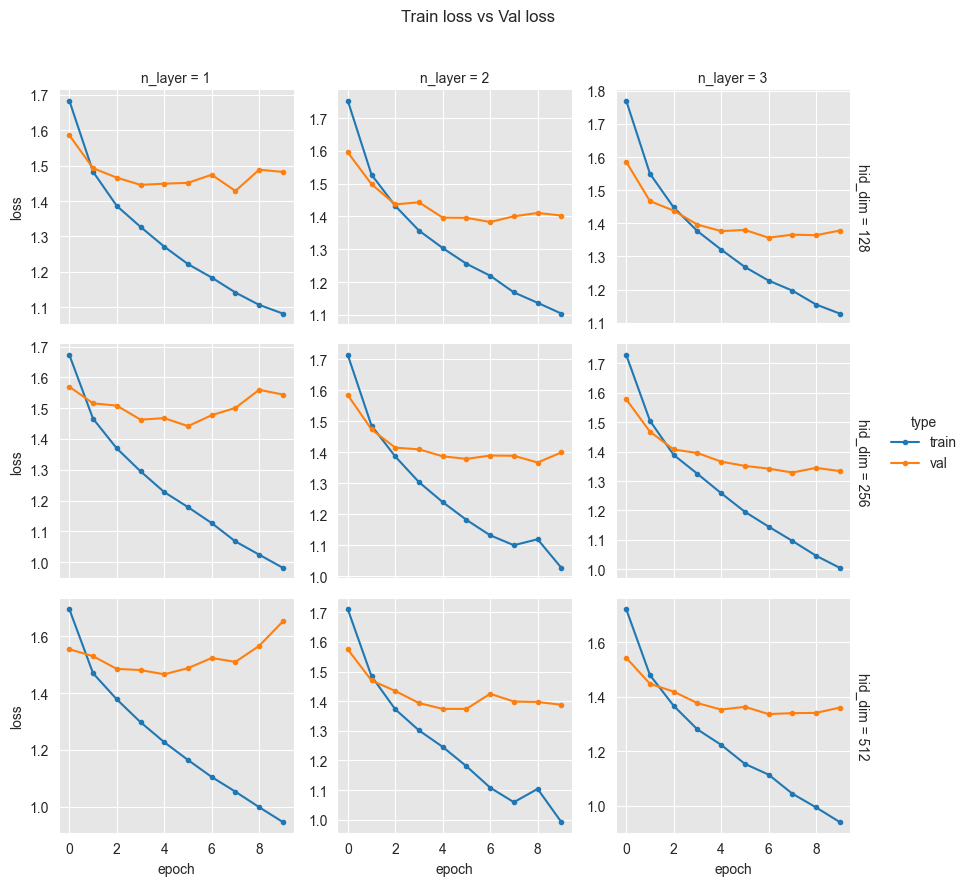

In [14]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

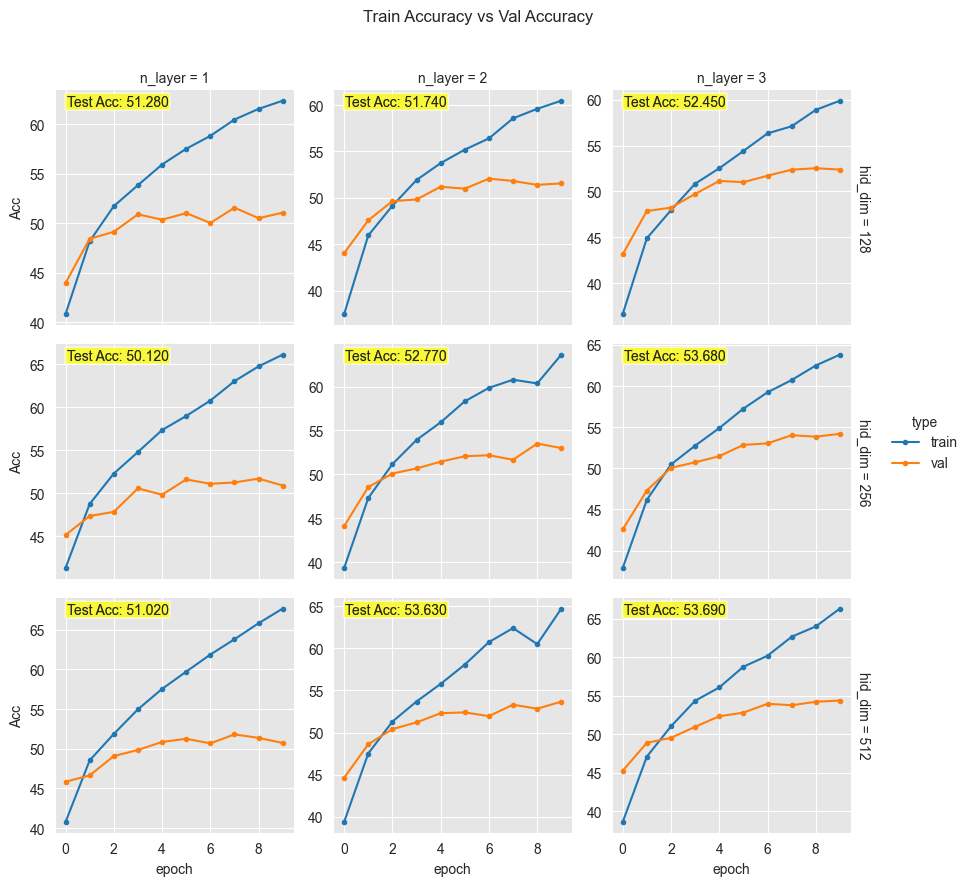

In [15]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

* Test accuracy 가 가장 높은 조합을 찾고 해당 성능에 근접한 조합을 고려해 parameter 를 설정
* 만약 layer = 3, hid_dim = 512 조합이 성능이 좋다면, 이를 고정하고 다른 parameter 를 변경하는 추가 실험을 진행한다.

#### learning rate 와 drop out 비율에 대한 추가 실험

In [12]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr_drop"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 512
args.n_layer = 3
args.act = 'relu'


# ====== Regularization ======= #
# args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
# args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.1, 0.05, 0.001, 0.00025]
list_var2 = [0.1, 0.25, 0.5]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # == args.name_var1 = var1
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_lr_drop', in_dim=3072, out_dim=10, hid_dim=512, n_layer=3, act='relu', use_bn=True, l2=1e-05, use_xavier=True, optim='Adam', epoch=10, train_batch_size=256, test_batch_size=1024, lr=0.1, dropout=0.1)
Epoch 0, Acc(train/val): 23.91/30.35, Loss(train/val) inf/inf. Took 29.61 sec
Epoch 1, Acc(train/val): 32.16/30.23, Loss(train/val) 1.86/inf. Took 29.51 sec
Epoch 2, Acc(train/val): 35.28/36.25, Loss(train/val) 1.78/inf. Took 29.81 sec
Epoch 3, Acc(train/val): 36.11/37.06, Loss(train/val) 1.75/inf. Took 29.49 sec
Epoch 4, Acc(train/val): 37.90/39.24, Loss(train/val) 1.72/inf. Took 29.47 sec
Epoch 5, Acc(train/val): 37.69/33.75, Loss(train/val) 1.74/1.85. Took 29.22 sec
Epoch 6, Acc(train/val): 25.05/24.88, Loss(train/val) 2.06/2.07. Took 29.23 sec
Epoch 7, Acc(train/val): 28.46/27.66, Loss(train/val) 1.94/inf. Took 29.28 sec
Epoch 8, Acc(train/val): 33.17/19.96, Loss(train/val) 1.84/inf. Took 29.20 sec
Epoch 9, Acc(train/val): 35.81/21.18, Loss(train/val) 1.79/inf.

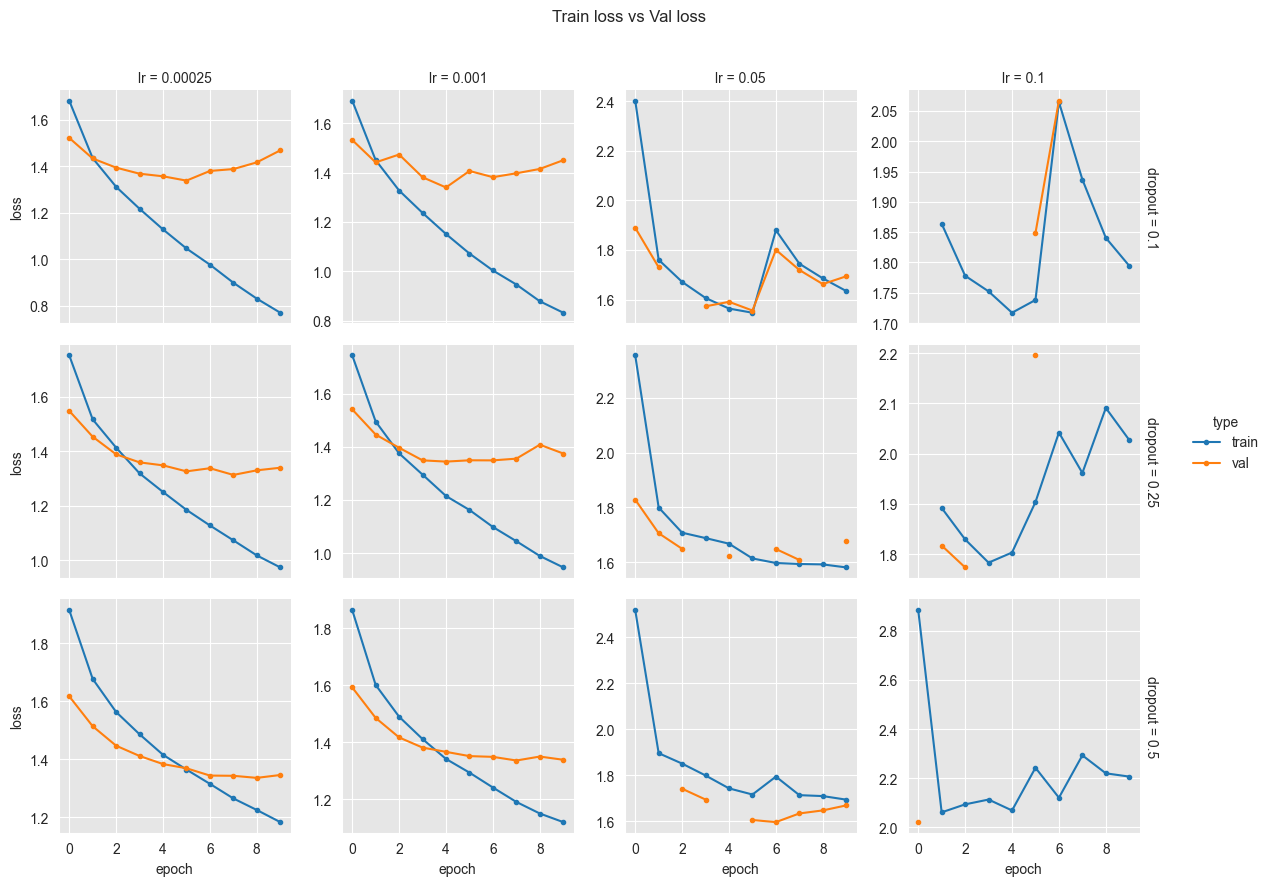

In [19]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp1_lr_drop')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

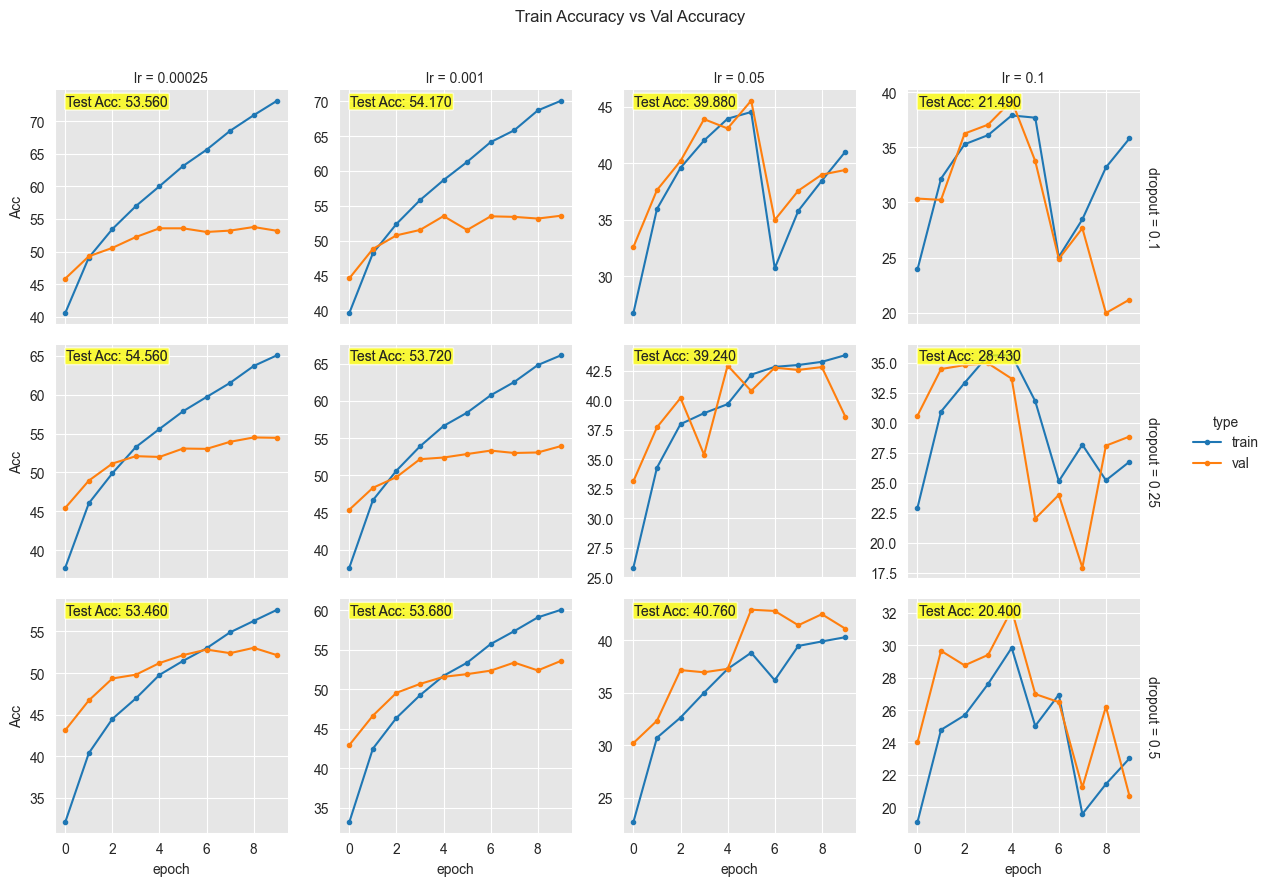

In [20]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp1_lr_drop')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)